# ECOM90025 ADA: Tutorial 8 in Week 9

- Covering materials from week 8 lecture: FWL, DML.

# My contact:
- Name: Zheng Fan
- Email: fan.z@unimelb.edu.au
- Send me an email if you have any general or conceptual questions
- I'm also happy to stay for a while after the tutorial.
- Consultataion: meet Dr Yong Song every Tuesday 1-2pm at FBE level-3 360.
- Special consideration: visit Stop 1.

# Tutorial participation 
- You need to actively participate instead of just showing up. 
- Attendance does not guarantee marks. 
- You may get a maximum of 10 points out of 11 tutorials.
- If you unable to come to school, seek help from Stop 1.

# Software:
- Google Colab is a free online platform where you can execute your code (especially for Python) and write text (LaTeX and Html) without any software installed.
- Local Jupyter Lab, which has been demonstrated during the lecture.
- Local Jupyter Notebook from Anaconda (My personal preference). Just download Anaconda, and then open Jupyter Notebook.
- Other IDE such as PyCharm, but I'm not very comfortable with using PyCharm. From what I know, the code saved in PyCharm is .py but not .ipynb, which may requires some conversion.

Although you can always use Colab, It is recommended to have a local machine installed.

#### You may access my tutorial code via: https://github.com/zhengf1/2023-S2-ADA or Canvas after Wednesday afternoon.
- <font color="red">
If you are using Google Colab, you can simply copy paste the code; or you can upload this ".ipynb" notebook file to Google Colab, which would look exactly the same as local Jupyter machine.
    </font>

# Frisch–Waugh–Lovell theorem

Suppose the true model is 

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 +\epsilon$$

If we are interested in $\beta_2$, instead of regressing y on both $x_1$ and $x_2$, we can do the following.

Namely, we can first estimate 

$$ x_2 \sim x_1 + e_1$$

Then we can regress y on $x_1$

$$ y \sim x_1 + e_2$$

Then we regress 

$$\hat{e}_2 \sim \hat{e}_1$$

Then the coefficient of $\hat{e}_1$ is the same as $\beta_2$.

#### alternatively

We can indeed get the same results via a 2-Stage Least Squares instead of 3 steps.

Namely, we can first estimate 

$$ x_2 \sim x_1 + e_1$$

Then we can regress y on the residual

$$ y \sim \hat{e}_1$$

Then the coefficient of $\hat{e}_1$ is the same as $\beta_2$.

#### a simple simulation to show the idea

In [1]:
import numpy as np
import statsmodels.api as sm

np.random.seed(0)

x1 = np.random.normal(-1, 1, 100)
x2 = np.random.normal(1, 1, 100)
e = np.random.normal(0, 1, 100)

a = 0
b1 = 1
b2 = 2

y = a + b1 * x1 + b2 * x2 + e

In [2]:
# Full Equation
X_full = np.column_stack((x1, x2))
X_full = sm.add_constant(X_full)
full_eq = sm.OLS(y, X_full).fit()
print(full_eq.params)

[-0.04432991  1.06681637  2.04428585]


In [3]:
# FWL theorem 3 steps
eq3 = sm.OLS(x2, sm.add_constant(x1)).fit()
eq4 = sm.OLS(y, sm.add_constant(x1)).fit()
eq5 = sm.OLS(eq4.resid, eq3.resid).fit()
print(eq5.params)

[2.04428585]


In [4]:
# 2-Stage Least Squares
eq1 = sm.OLS(x2, sm.add_constant(x1)).fit()
eq2 = sm.OLS(y, sm.add_constant(eq1.resid)).fit()
print(eq2.params)

[1.1646017  2.04428585]


# Housekeeping code to start with

In [5]:
# !pip install econml

In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import patsy
from econml.dml import LinearDML
from econml.sklearn_extensions.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Tutorial

More Orange Juice and Heterogeneous LTE.

- Check the data, explain the variables, and describe their features. [some hints.](https://rdrr.io/cran/bayesm/man/orangeJuice.html)

- Consider a model
$$\log(move) = \beta \cdot income \times \log(price) + controls+ɛ$$
to learn price elasticity.
  - What is the treatment?
  - Drop *week* and *store* from *controls*.
  - Normalise numeric values and create dummy variables for *brand*.
  - Apply the linear double machine learning model to estimate the treatment effects.
  - Assume that all confounders are present.

- Plot the price elasticity for normalised *income* levels between $-1$ and $1$ and their 99\% confidence interval.

### What we are estimating?

We are trying to understand how sales would change in response to price for any given income level. The model can be written as

$$Y = \beta X*T + W + \epsilon$$

where Y: log(move); T: log(price); X: income; W: controls.

X  is the heterogeneity for the treatment effects.

## Load and understand the data

In [7]:
oj_data = pd.read_csv("https://www.dropbox.com/scl/fi/p87ibtcswr221ty5tbout/oj_data.csv?rlkey=qj4bd34srvujac45kkirv8qvw&dl=1")

In [8]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [9]:
oj_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28947 entries, 0 to 28946
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   store     28947 non-null  int64  
 1   brand     28947 non-null  object 
 2   week      28947 non-null  int64  
 3   logmove   28947 non-null  float64
 4   feat      28947 non-null  int64  
 5   price     28947 non-null  float64
 6   AGE60     28947 non-null  float64
 7   EDUC      28947 non-null  float64
 8   ETHNIC    28947 non-null  float64
 9   INCOME    28947 non-null  float64
 10  HHLARGE   28947 non-null  float64
 11  WORKWOM   28947 non-null  float64
 12  HVAL150   28947 non-null  float64
 13  SSTRDIST  28947 non-null  float64
 14  SSTRVOL   28947 non-null  float64
 15  CPDIST5   28947 non-null  float64
 16  CPWVOL5   28947 non-null  float64
dtypes: float64(13), int64(3), object(1)
memory usage: 3.8+ MB


## Construct Y, X and T variable

In [10]:
# Prepare data
Y = oj_data['logmove'].values
Y

array([ 9.01869549,  8.72323127,  8.25322765, ...,  9.50599061,
       10.9273763 ,  8.85936345])

In [11]:
T = np.log(oj_data["price"]).values
T

array([1.35325451, 1.35325451, 1.35325451, ..., 0.46373402, 0.39877612,
       0.55961579])

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(oj_data[['INCOME']].values)
pd.DataFrame(X)

,0
0,-0.225035
1,-0.225035
2,-0.225035
3,-0.225035
4,-0.225035
...,...
28942,1.238911
28943,1.238911
28944,1.238911
28945,1.238911


## Construct W: control variables. 
1. Normalise numeric values and create dummy variables for brand. 
2. Drop week and store from controls.

- W1: Everything, other than 'price', 'logmove', 'brand', 'week', 'store','INCOME'.
- W2: 'brand' dummy. 

W = [W1 W2]

Get all the control variables:

In [13]:
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
W1.shape

(28947, 11)

Convert 3 brands into 3 dummy variables

In [14]:
W2 = pd.get_dummies(oj_data[['brand']]).values 
W2

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

Put all the controls and dummy together

In [15]:
W = np.concatenate([W1, W2], axis=1)
pd.DataFrame(W)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0,0.0,1.0
1,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0,0.0,1.0
2,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0,0.0,1.0
3,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0,0.0,1.0
4,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28942,-0.557732,0.589494,2.757265,-0.225544,-0.749362,-0.548398,2.162847,0.267604,-0.952357,-1.84681,-0.479616,1.0,0.0,0.0
28943,-0.557732,0.589494,2.757265,-0.225544,-0.749362,-0.548398,2.162847,0.267604,-0.952357,-1.84681,-0.479616,1.0,0.0,0.0
28944,-0.557732,0.589494,2.757265,-0.225544,-0.749362,-0.548398,2.162847,0.267604,-0.952357,-1.84681,-0.479616,1.0,0.0,0.0
28945,-0.557732,0.589494,2.757265,-0.225544,-0.749362,-0.548398,2.162847,0.267604,-0.952357,-1.84681,-0.479616,1.0,0.0,0.0


### Apply the linear double machine learning model to estimate the treatment effects.

In [16]:
#default model is Lasso
est = LinearDML()
est.fit(Y, T, X=X, W=W)

Y: log(move); T: log(price); X: income; W: controls.

In [17]:
# Find the income levels: from data X
X0 = np.asarray(X)
X_level = np.unique(X0, axis=0) # .ravel() to transfer into 1-dimension array

# Find the heterigeneous treatment effect for each X
TE = est.const_marginal_effect(X_level) # est.effect(X_level) will do the same job in this case

# print the TE for each given income level
pd.DataFrame([X_level.ravel(), TE])

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,-2.655432,-2.302743,-2.196445,-2.055053,-1.869456,-1.694782,-1.686528,-1.641132,-1.517378,-1.267328,...,1.180248,1.212999,1.238911,1.289870,1.297821,1.357129,1.513218,1.538324,2.183651,2.194271
1,-2.992782,-2.940874,-2.925230,-2.904420,-2.877104,-2.851396,-2.850182,-2.843500,-2.825286,-2.788485,...,-2.428257,-2.423437,-2.419623,-2.412123,-2.410953,-2.402224,-2.379252,-2.375557,-2.280579,-2.279016


How do we interpret the Price Elasticity of Demand?

$$E_{\langle P\rangle}=\frac{\Delta Q / Q}{\Delta P / P}$$

We can say that the price elasticity of demand is the percentage change in demand for a commodity due to a given percentage change in the price.

### Plot the price elasticity for income levels (from the data) and their 99% confidence interval.

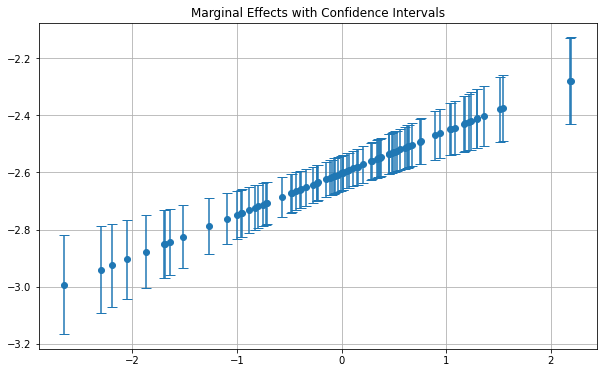

In [18]:
# Find the 99% Confidence Interval of heterigeneous treatment effect for each X
me_inter = est.const_marginal_effect_interval(X_level, alpha=0.01)
lower_bounds = me_inter[0] 
upper_bounds = me_inter[1] 

plt.figure(figsize=(10, 6))
plt.errorbar(X_level, TE, yerr=[TE - lower_bounds, upper_bounds - TE],
             fmt='o', capsize=5)
plt.title('Marginal Effects with Confidence Intervals')
plt.grid(True)
plt.show()

### Plot the price elasticity for normalised income levels between  −1  and  1  and their 99% confidence interval.

In [19]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

In [20]:
# te_pred = est.effect(X_test) 
te_pred = est.const_marginal_effect(X_test)
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.01)

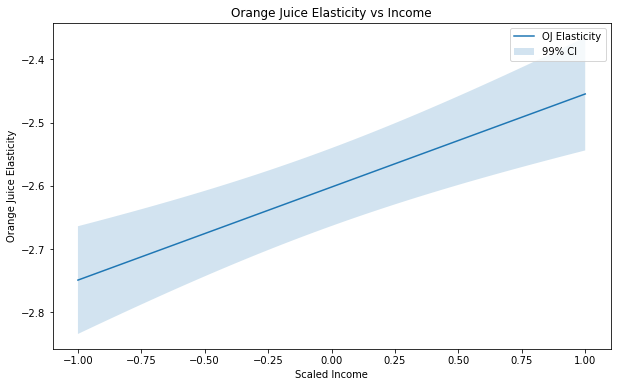

In [21]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=0.2, label="99% CI")
plt.xlabel('Scaled Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()